In [137]:
import warnings
warnings.filterwarnings("ignore")

import re
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import CoxPHFitter

# Modèle de Cox à Hasards Proportionnels - Performance
## Import des données

In [163]:
df = pd.read_csv('../data/df_duree.csv',sep = ',')

In [139]:
df['arrete'] = pd.to_datetime(df['arrete']) 
df['date_entree_defaut'] = pd.to_datetime(df['date_entree_defaut']) 

## Selection des variables d'intérêt

In [140]:
liste_var = list(set(['Motif', 'MT_EAD_DNE_CHR_d', 'niv_gravite_mtf_dfs',
       'MTF', 'MT_REV_PFI', 'MT_FMG',
       'ANC_PRO_MAX_PFI', 'EAD_1an_avant_def', 'CP',
       'CD_DNE_CHR_LGD_SAIN', 'max_age_ctx', 'TX_APPOR','DET', 'arrete', 'cd_op','date_entree_defaut','MTF', 'dls_mep_entree_def','ANC_PRO_MAX_PFI_2','nb_empr_ope','MT_REST_VIVRE','DET', 'arrete', 'cd_op','date_entree_defaut','DT_MEP_OPE']))  
df = df[liste_var]

In [164]:
df['ANC_PRO_MAX_PFI_2'] = df['ANC_PRO_MAX_PFI_2'].apply(lambda x : 1 if x == '(-inf, 30.50)' else 2 if x == '[30.50, 68.50)' else 3 if x == '[68.50, 151.50)' else 4)

df['MT_REST_VIVRE'] = df['MT_REST_VIVRE'].apply(lambda x : 1 if x == '[2418.50, inf)' else 2 )

### Split des données : Entraînement / Validation

In [142]:
df_validation = df[df['arrete']>"2020-06-30"]
data_train = df[df['arrete']<"2020-01-30"]

### Création des variables modélisant le temps passé pour le modèle

In [143]:
data_train['start'] = 0
data_train['stop'] = data_train['arrete'] - data_train['date_entree_defaut']
data_train['stop'] = data_train['stop'].dt.days

df_validation['start'] = 0
df_validation['stop'] = df_validation['arrete'] - df_validation['date_entree_defaut']
df_validation['stop'] = df_validation['stop'].dt.days

In [144]:
data_train['id'] = data_train['cd_op'].apply(lambda x: re.sub(r'\D', '', str(x)))
df_validation['id'] = df_validation['cd_op'].apply(lambda x: re.sub(r'\D', '', str(x)))

In [145]:
data_train.id = data_train.id.astype('int')

In [146]:
data_train.loc[(data_train['start'] == data_train['stop']) & (data_train['start'] == 0) & data_train['DET'], 'stop'] = 0.5  # car le modele n'accepte pas les individus qui sortent de la survie au moment ou ils y entrent donc on remplace les 0 par 0.5.

df_validation.loc[(df_validation['start'] == df_validation['stop']) & (df_validation['start'] == 0) & df_validation['DET'], 'stop'] = 0.5 

In [147]:
data_train = data_train.select_dtypes(exclude=["datetime64"])
df_validation = df_validation.select_dtypes(exclude=["datetime64"])

In [148]:
data_train.drop(columns = ["cd_op"], inplace = True)
df_validation.drop(columns = ["cd_op"], inplace = True)

# Modelisation

In [149]:
df_validation.drop(columns = ['start','DET', 'id'],inplace = True )

In [150]:
cph = CoxPHFitter(penalizer=0.1)  
cph.fit(data_train.drop(columns = ['id','start']), duration_col='stop', event_col='DET')

<lifelines.CoxPHFitter: fitted with 9842 total observations, 5742 right-censored observations>

In [151]:
cph.check_assumptions(data_train.drop(columns = ['id','start']))

The ``p_value_threshold`` is set at 0.01. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.


<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 9842 total observations, 5742 right-censored observations>
         test_name = proportional_hazard_test

---
                          test_statistic      p  -log2(p)
ANC_PRO_MAX_PFI     km              1.02   0.31      1.68
                    rank            0.70   0.40      1.31
ANC_PRO_MAX_PFI_2   km              0.04   0.85      0.24
                    rank            0.00   0.96      0.06
CD_DNE_CHR_LGD_SAIN km             10.72 <0.005      9.89
                    rank           14.71 <0.005     12.96
CP                  km              2.35   0.13      2.99
                    rank            1.75   0.19      2.43
DT_MEP_OPE          km              0.36   0.55      0.86
                    rank            0.42   0.51      0.96
EAD_1an_avant_def   km              0.56   0.45      1.14
                    rank            0.73   0.39      1.35
MTF                 km              1.53   0.22      2.21
                    rank            1.76   0.18      2.44
MT_EAD_DNE_CHR_d    km              0.01   0.90      0.15
                    rank            0.18   0.67      0.58
MT_FMG              km              1.05   0.30      1.71
                    rank            1.08   0.30      1.74
MT_REST_VIVRE       km              0.50   0.48      1.07
                    rank            0.22   0.64      0.65
MT_REV_PFI          km              4.80   0.03      5.14
                    rank            6.07   0.01      6.19
Motif               km             18.68 <0.005     15.98
                    rank           19.36 <0.005     16.50
TX_APPOR            km              2.19   0.14      2.84
                    rank            1.83   0.18      2.51
dls_mep_entree_def  km              0.03   0.85      0.23
                    rank            0.02   0.87      0.19
max_age_ctx         km              1.74   0.19      2.42
                    rank            2.50   0.11      3.13
nb_empr_ope         km              0.57   0.45      1.16
                    rank            0.41   0.52      0.94
niv_gravite_mtf_dfs km              9.75 <0.005      9.12
                    rank            9.70 <0.005      9.09



1. Variable 'CD_DNE_CHR_LGD_SAIN' failed the non-proportional test: p-value is 0.0001.

   Advice: with so few unique values (only 5), you can include `strata=['CD_DNE_CHR_LGD_SAIN', ...]`
in the call in `.fit`. See documentation in link [E] below.

2. Variable 'MT_REV_PFI' failed the non-proportional test: p-value is 0.0137.

   Advice 1: the functional form of the variable 'MT_REV_PFI' might be incorrect. That is, there may
be non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'MT_REV_PFI' using pd.cut, and then specify it in
`strata=['MT_REV_PFI', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


3. Variable 'niv_gravite_mtf_dfs' failed the non-proportional test: p-value is 0.0018.

   Advic

[]

In [152]:
cph.AIC_partial_

64657.57515577646

In [153]:
cph.concordance_index_

0.7172823654740608

On obtient 0.73 de concordance des index ce qui est bien meilleur que celui obtenu avec le modèle d'interprétabilité

## Courbes de Survie

<Axes: >

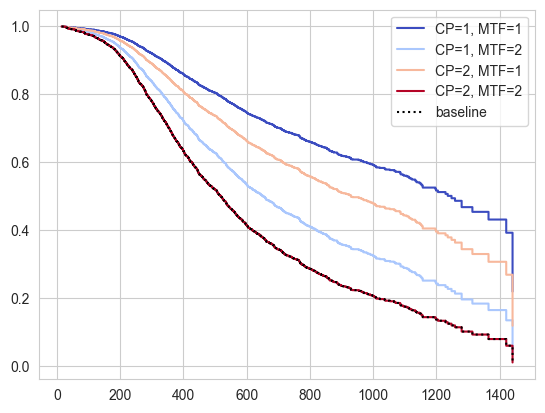

In [154]:
cph.plot_partial_effects_on_outcome(['CP','MTF'], values=[ [1,  1], [1,  2], [2, 1], [2,  2]], cmap='coolwarm')

<Axes: >

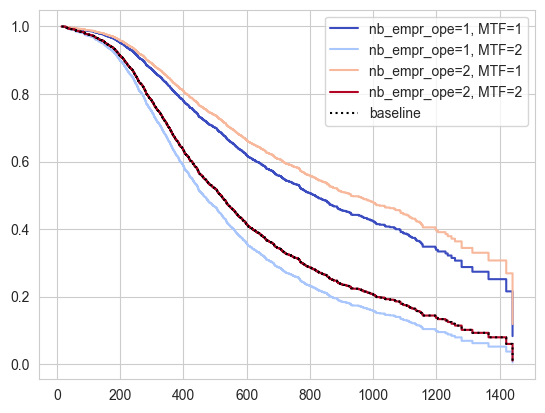

In [155]:
cph.plot_partial_effects_on_outcome(['nb_empr_ope','MTF'], values=[ [1,  1], [1,  2], [2, 1], [2,  2]], cmap='coolwarm')

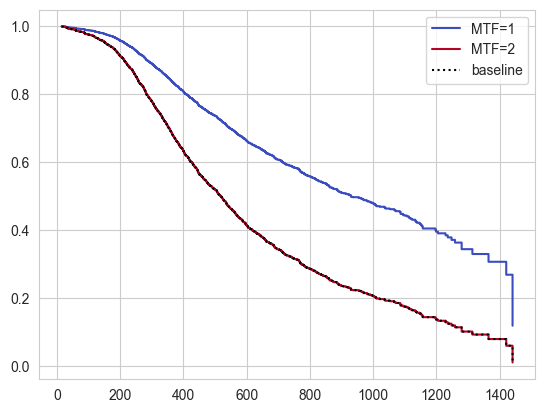

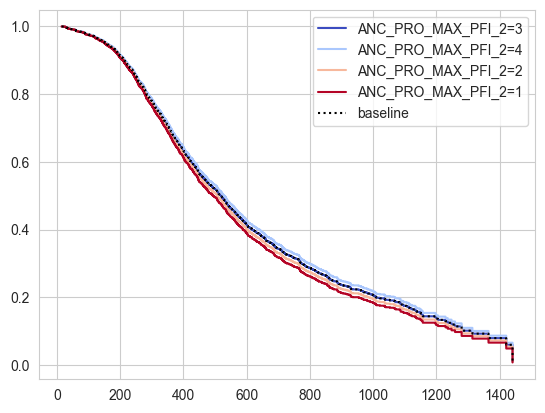

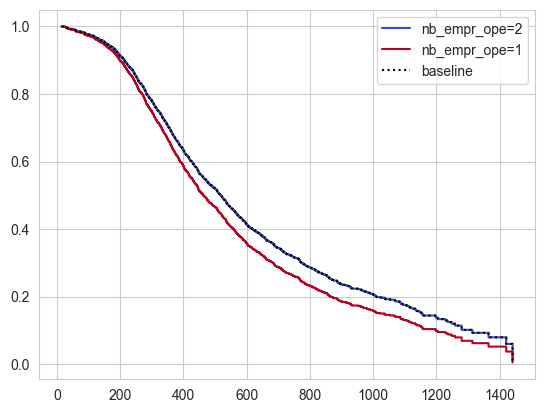

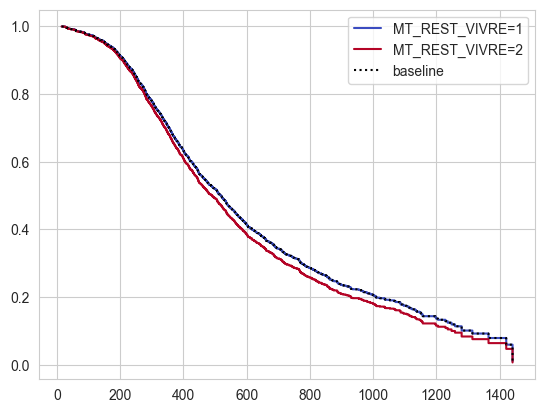

In [156]:
for col in data_train[['MTF','ANC_PRO_MAX_PFI_2','nb_empr_ope','MT_REST_VIVRE']].columns:
    cph.plot_partial_effects_on_outcome(col, values=data_train[col].unique(), cmap='coolwarm')

# Predictions

In [157]:
pred = cph.predict_survival_function(df_validation)

In [158]:
pred = pred.transpose()

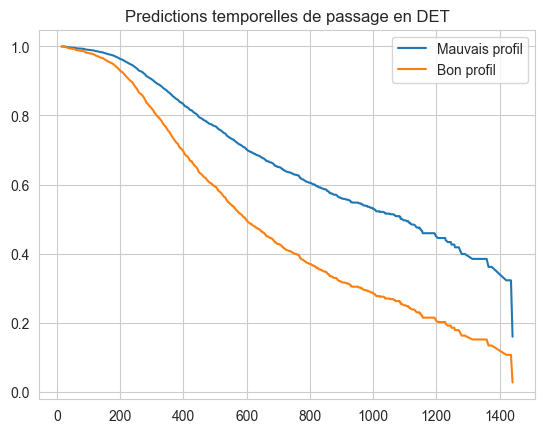

In [159]:
survival_function_observation_15 = pred.iloc[15]
survival_function_observation_20 = pred.iloc[20]

plt.plot(survival_function_observation_15, label='Mauvais profil')
plt.plot(survival_function_observation_20, label='Bon profil')

plt.title("Predictions temporelles de passage en DET")
plt.legend()
plt.show()

In [165]:
bon = pd.read_csv("../data/df_ph.csv")

In [166]:
bon

,cd_op,AGE_EMP1,MT_CHA_HORS_OPE_PFI,NB_LO_HOP,fl_fonc,CD_DNE_CHR_LGD_SAIN,MT_REV_PFI,NB_RP_HOP,MT_REST_VIVRE,TX_ENDET,...,Motif,Situation_fam,Nature,Solution_echec,Nature_op,MTF,ETAT_CIVIL,CSP,CP,ANC_PRO_MAX_PFI_2
0,I860708600,75,0.0,1.0,1,2.0,53781.0,1.0,"[2418.50, inf)",30.11,...,Motif mauvais,Bonne situation,Bonne nature,Bonne solution,Bonne nature,Bon MTF,Mauvais etat,Bonne CSP,CP moyen,"[68.50, 151.50)"
1,I950404213,69,0.0,0.0,0,1.0,42070.0,1.0,"[2418.50, inf)",30.11,...,Motif mauvais,Bonne situation,Mauvaise nature,Bonne solution,Mauvaise nature,Mauvais MTF,Bon etat,Mauvaise CSP,CP moyen,"[151.50, inf)"
2,I950706618,71,0.0,1.0,1,1.0,46380.0,0.0,"[2418.50, inf)",30.11,...,Motif moyen,Bonne situation,Mauvaise nature,Bonne solution,Mauvaise nature,Mauvais MTF,Bon etat,Bonne CSP,CP tres mauvais,"[30.50, 68.50)"
3,I950901248,59,0.0,1.0,1,2.0,18822.0,1.0,"[2418.50, inf)",30.11,...,Motif moyen,Mauvaise situation,Mauvaise nature,Bonne solution,Mauvaise nature,Mauvais MTF,Mauvais etat,Mauvaise CSP,CP moyen,"[151.50, inf)"
4,I960300578,52,2484.0,1.0,1,1.0,12804.0,1.0,"[2418.50, inf)",30.11,...,Motif mauvais,Bonne situation,Mauvaise nature,Bonne solution,Mauvaise nature,Mauvais MTF,Bon etat,Mauvaise CSP,CP moyen,"(-inf, 30.50)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22688,M220200817,49,15840.0,0.0,1,2.0,66960.0,1.0,"[2418.50, inf)",29.19,...,Motif moyen,Bonne situation,Mauvaise nature,Bonne solution,Mauvaise nature,Mauvais MTF,Bon etat,Mauvaise CSP,CP tres mauvais,"[151.50, inf)"
22689,M220207473,38,19872.0,1.0,0,2.0,143412.0,0.0,"[2418.50, inf)",20.23,...,Motif moyen,Bonne situation,Mauvaise nature,Bonne solution,Mauvaise nature,Mauvais MTF,Bon etat,Mauvaise CSP,CP moyen,"[68.50, 151.50)"
22690,M220330795,41,4164.0,1.0,0,2.0,71652.0,1.0,"(-inf, 2418.50)",43.81,...,Motif moyen,Bonne situation,Mauvaise nature,Bonne solution,Mauvaise nature,Mauvais MTF,Bon etat,Bonne CSP,CP moyen,"[30.50, 68.50)"
22691,M220505830,55,4068.0,0.0,0,2.0,38846.0,1.0,"(-inf, 2418.50)",20.91,...,Motif moyen,Bonne situation,Mauvaise nature,Bonne solution,Mauvaise nature,Mauvais MTF,Bon etat,Bonne CSP,CP mauvais,"[151.50, inf)"


In [173]:
df = df[bon.columns]

KeyError: "['CD_MTF_ENE_CTX'] not in index"

In [170]:
df == bon

ValueError: Can only compare identically-labeled (both index and columns) DataFrame objects

In [169]:
bon['Motif'] = bon['Motif'].apply(lambda x : 3 if x == 'Motif tres mauvais' else 2 if x == 'Motif mauvais' else 1)

bon['Situation_fam'] = bon['Situation_fam'].apply(lambda x : 2 if x == 'Mauvaise situation' else 1)

bon['Nature'] = bon['Nature'].apply(lambda x : 2 if x == 'Mauvaise nature' else 1)

bon['Solution_echec'] = bon['Solution_echec'].apply(lambda x : 2 if x == 'Mauvaise solution' else 1)

bon['Nature_op'] = bon['Nature_op'].apply(lambda x : 2 if x == 'Mauvaise nature' else 1)

bon['CD_MTF_ENE_CTX'] = bon['MTF'].apply(lambda x : 2 if x == 'Mauvais MTF' else 1)

bon['ETAT_CIVIL'] = bon['ETAT_CIVIL'].apply(lambda x : 2 if x == 'Mauvais etat' else 1)

bon['CSP'] = bon['CSP'].apply(lambda x : 2 if x == 'Mauvaise CSP' else 1)

bon['MTF'] = bon['MTF'].apply(lambda x : 2 if x == 'Mauvais MTF' else 1)

bon['nb_empr_ope'] = bon['nb_empr_ope'].apply(lambda x : 1 if x == 'Un emprunteur' else 2)

bon['ANC_PRO_MAX_PFI_2'] = bon['ANC_PRO_MAX_PFI_2'].apply(lambda x : 1 if x == '(-inf, 30.50)' else 2 if x == '[30.50, 68.50)' else 3 if x == '[68.50, 151.50)' else 4)

bon['MT_REST_VIVRE'] = bon['MT_REST_VIVRE'].apply(lambda x : 1 if x == '[2418.50, inf)' else 2 )

bon['CP'] = bon['CP'].apply(lambda x : 3 if x == 'CP tres mauvais' else 2 if x == 'CP mauvais' else 1)

In [171]:
df

,cd_op,AGE_EMP1,MT_CHA_HORS_OPE_PFI,NB_LO_HOP,fl_fonc,CD_DNE_CHR_LGD_SAIN,MT_REV_PFI,NB_RP_HOP,MT_REST_VIVRE,TX_ENDET,...,Motif,Situation_fam,Nature,Solution_echec,Nature_op,MTF,ETAT_CIVIL,CSP,CP,ANC_PRO_MAX_PFI_2
0,I860708600,75,0.0,1.0,1,2.0,53781.0,1.0,1,30.11,...,2,1,1,1,1,1,2,1,1,3
1,I950404213,69,0.0,0.0,0,1.0,42070.0,1.0,1,30.11,...,2,1,2,1,2,2,1,2,1,4
2,I950706618,71,0.0,1.0,1,1.0,46380.0,0.0,1,30.11,...,1,1,2,1,2,2,1,1,3,2
3,I950901248,59,0.0,1.0,1,2.0,18822.0,1.0,1,30.11,...,1,2,2,1,2,2,2,2,1,4
4,I960300578,52,2484.0,1.0,1,1.0,12804.0,1.0,1,30.11,...,2,1,2,1,2,2,1,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22688,M220200817,49,15840.0,0.0,1,2.0,66960.0,1.0,1,29.19,...,1,1,2,1,2,2,1,2,3,4
22689,M220207473,38,19872.0,1.0,0,2.0,143412.0,0.0,1,20.23,...,1,1,2,1,2,2,1,2,1,3
22690,M220330795,41,4164.0,1.0,0,2.0,71652.0,1.0,2,43.81,...,1,1,2,1,2,2,1,1,1,2
22691,M220505830,55,4068.0,0.0,0,2.0,38846.0,1.0,2,20.91,...,1,1,2,1,2,2,1,1,2,4


In [172]:
bon

,cd_op,AGE_EMP1,MT_CHA_HORS_OPE_PFI,NB_LO_HOP,fl_fonc,CD_DNE_CHR_LGD_SAIN,MT_REV_PFI,NB_RP_HOP,MT_REST_VIVRE,TX_ENDET,...,Situation_fam,Nature,Solution_echec,Nature_op,MTF,ETAT_CIVIL,CSP,CP,ANC_PRO_MAX_PFI_2,CD_MTF_ENE_CTX
0,I860708600,75,0.0,1.0,1,2.0,53781.0,1.0,1,30.11,...,1,1,1,1,1,2,1,1,3,1
1,I950404213,69,0.0,0.0,0,1.0,42070.0,1.0,1,30.11,...,1,2,1,2,2,1,2,1,4,2
2,I950706618,71,0.0,1.0,1,1.0,46380.0,0.0,1,30.11,...,1,2,1,2,2,1,1,3,2,2
3,I950901248,59,0.0,1.0,1,2.0,18822.0,1.0,1,30.11,...,2,2,1,2,2,2,2,1,4,2
4,I960300578,52,2484.0,1.0,1,1.0,12804.0,1.0,1,30.11,...,1,2,1,2,2,1,2,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22688,M220200817,49,15840.0,0.0,1,2.0,66960.0,1.0,1,29.19,...,1,2,1,2,2,1,2,3,4,2
22689,M220207473,38,19872.0,1.0,0,2.0,143412.0,0.0,1,20.23,...,1,2,1,2,2,1,2,1,3,2
22690,M220330795,41,4164.0,1.0,0,2.0,71652.0,1.0,2,43.81,...,1,2,1,2,2,1,1,1,2,2
22691,M220505830,55,4068.0,0.0,0,2.0,38846.0,1.0,2,20.91,...,1,2,1,2,2,1,1,2,4,2


In [ ]:
df

In [ ]:
[x for x in bon.columns if x not in df.columns]

In [ ]:
'CD_MTF_ENE_CTX' in df.columns